In [1]:
!nvidia-smi

Mon May 27 17:33:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              48W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd ./drive/MyDrive/NewsGeneration-NLP-Teknofest/Model/

except ImportError:
    print("You are not in a Google Colab environment.")
    pass

Mounted at /content/drive
/content/drive/MyDrive/NewsGeneration-NLP-Teknofest/Model


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from tensorflow.keras.utils import plot_model

from tensorflow import expand_dims

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D

from tensorflow.keras.applications import MobileNetV2, mobilenet_v2

from tensorflow.keras.layers import Conv2D, Flatten, Reshape
from tensorflow.keras.layers import Embedding, LSTM, Dense, concatenate

from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

In [2]:
import get_data

In [3]:
df = get_data.load_data()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1842 entries, 0 to 1841
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Title                1842 non-null   object
 1   Content              1842 non-null   object
 2   Content_url          1842 non-null   object
 3   News_type            1842 non-null   object
 4   Day_month_year_hour  1842 non-null   object
 5   Img_url              1842 non-null   object
 6   img_path             1842 non-null   object
dtypes: object(7)
memory usage: 100.9+ KB
None


In [4]:
img_preprocessor = get_data.PreProcessImg(df)

loaded_imgs = img_preprocessor.load_img(target_size=(224, 224))
image_data = img_preprocessor.img_to_array()

img_preprocessor.get_size_info(loaded_imgs)
print('Image shapes: ', image_data.shape)

Max width:  224
Min width:  224
Mean width: 224.0
Standard deviation of widths: 0.0
==
Max height: 224
Min height: 224
Mean height: 224.0
Standard deviation of heights: 0.0
Image shapes:  (10, 224, 224, 3)


In [5]:
tokenizer = get_data.PreprocessText(df['Title'])

padded_tokens = tokenizer.padded_tokens
max_tokens = tokenizer.max_tokens
vocab_size = tokenizer.vocab_size

start_token = tokenizer.word_index[tokenizer.start_mark.strip()]
end_token = tokenizer.word_index[tokenizer.end_mark.strip()]

X_images, X_texts, y_texts = tokenizer.generate_data(image_data)

tokenizer.get_info()

Max tokens:  11
Min tokens:  7
Mean tokens:  9
Standard deviation of tokens:  1
Vocabulary Size:  72
Shape of padded tokens:  (10, 11)
X_images shape:  (100, 224, 224, 3)
X_texts shape:  (100, 11)
y_texts shape:  (100, 72)


In [10]:
class Img2TextModel():
    """
    # Image captioning model that generate meaningfull context and title from and image.
    """
    @staticmethod
    def CNN_encoder():
        """
        # Encoder with MobileNetV2.
        """
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        base_model.trainable = False

        input_layer = Input(shape=(224, 224, 3), name='encoder_input')
        x = base_model(input_layer)
        x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu')(x)
        x = GlobalAveragePooling2D(name='global_average_pooling2d')(x)
        x = Dense(256, activation='relu', name='encoder_dense_1')(x)
        output_layer = Dense(128, activation='relu', name='encoder_output')(x)

        return input_layer, output_layer

    @staticmethod
    def LSTM_decoder():
        """
        # Decoder with LSTM.
        """
        input_layer = Input(shape=(None, ), name='decoder_input')
        embedding_layer = Embedding(input_dim=vocab_size, output_dim=300, input_length=max_tokens, name='decoder_embedding')(input_layer)
        lstm_layer = LSTM(256, return_sequences=True, name='LSTM_layer_1')(embedding_layer)
        lstm_layer = LSTM(128, name='LSTM_layer_2')(lstm_layer)

        return input_layer, lstm_layer

    def build_model(self):
        """
        # Concat layers and build model.
        """
        encoder_input, encoder_output = self.CNN_encoder()
        decoder_input, decoder_output = self.LSTM_decoder()

        combined = concatenate([encoder_output, decoder_output])
        output = Dense(vocab_size, activation='softmax', name='model_output')(combined)

        self.model = Model(inputs=[encoder_input, decoder_input], outputs=output)
        self.model.compile(loss='categorical_crossentropy', optimizer='adam')

        return self.model

In [11]:
model = Img2TextModel()

model = model.build_model()

9406464/9406464 [==============================] - 1s 0us/step


In [12]:
es = EarlyStopping(monitor='loss', patience=5, verbose=1)

model.fit([X_images, X_texts],
          y_texts,
          epochs=50,
          batch_size=64,
          callbacks=[es])

Epoch 1/50
391/391 [==============================] - 35s 65ms/step - loss: 2.4879
Epoch 2/50
391/391 [==============================] - 13s 34ms/step - loss: 2.1216
Epoch 3/50
391/391 [==============================] - 13s 34ms/step - loss: 1.9276
Epoch 4/50
391/391 [==============================] - 13s 32ms/step - loss: 1.7413
Epoch 5/50
391/391 [==============================] - 13s 32ms/step - loss: 1.5635
Epoch 6/50
391/391 [==============================] - 12s 31ms/step - loss: 1.3762
Epoch 7/50
391/391 [==============================] - 12s 30ms/step - loss: 1.1851
Epoch 8/50
391/391 [==============================] - 12s 31ms/step - loss: 1.0120
Epoch 9/50
391/391 [==============================] - 13s 32ms/step - loss: 0.8442
Epoch 10/50
391/391 [==============================] - 12s 31ms/step - loss: 0.6974
Epoch 11/50
391/391 [==============================] - 12s 30ms/step - loss: 0.5705
Epoch 12/50
391/391 [==============================] - 12s 31ms/step - loss: 0.4685
E

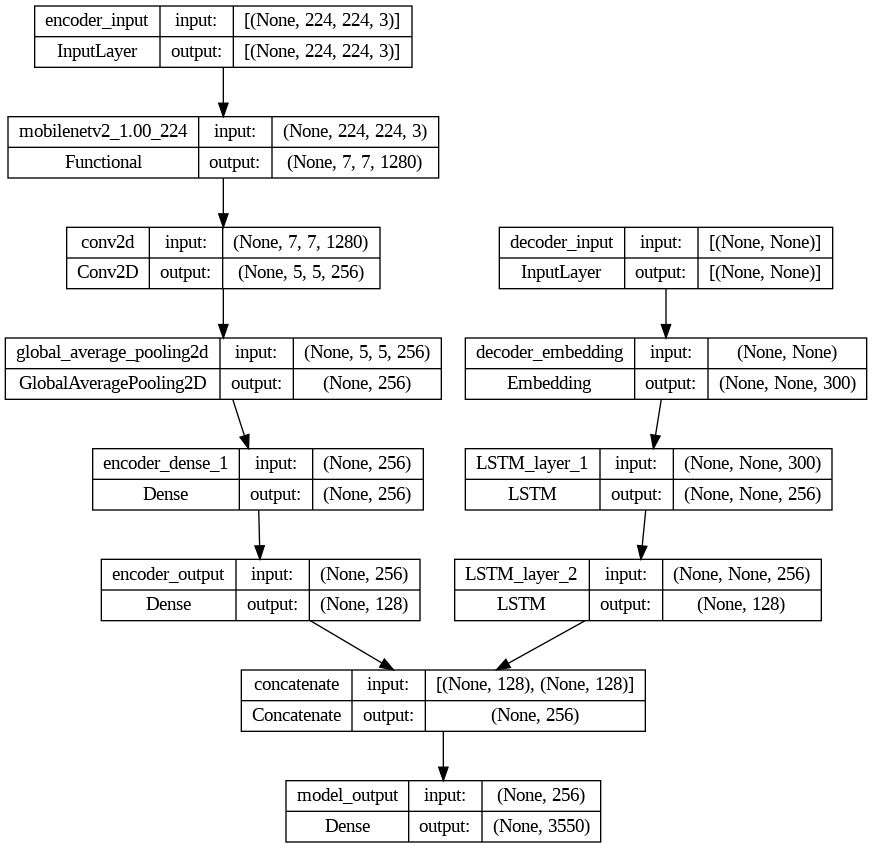

In [13]:
plot_model(model, show_shapes=True)

In [14]:
model.save('img2text_model.h5')

trained_model = load_model('img2text_model.h5')

trained_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)           2257984   ['encoder_input[0][0]']       
 tional)                                                                                          
                                                                                                  
 conv2d (Conv2D)             (None, 5, 5, 256)            2949376   ['mobilenetv2_1.00_224[0][0]']
                                                                                                  
 decoder_input (InputLayer)  [(None, None)]               0         []                        

In [18]:
def generate_text(index):

  test_image = image_data[index]
  real_title = df['Title'][index]

  initial_caption = '<start>'
  max_caption_length = 20

  initial_caption_seq = tokenizer.texts_to_sequences([initial_caption])[0]
  initial_caption_seq = pad_sequences([initial_caption_seq], maxlen=max_tokens)

  final_caption = []

  for i in range(100):
      predictions = trained_model.predict([np.expand_dims(test_image, axis=0), initial_caption_seq])

      predicted_word_index = np.argmax(predictions)

      try:
        predicted_word = tokenizer.index_word[predicted_word_index]
      except KeyError:
        predicted_word = "<UNKNOWN>"
        pass

      if predicted_word == '<end>':
          break

      final_caption.append(predicted_word)

      initial_caption_seq = pad_sequences([initial_caption_seq[0].tolist() + [predicted_word_index]], maxlen=max_tokens)

  final_caption = ' '.join(final_caption)

  plt.imshow(test_image)
  plt.axis("off")
  plt.show()
  print()
  print("Generated title")
  print(final_caption)
  # print("Real title")
  # print(real_title)

1/1 [==============================] - 0s 24ms/step


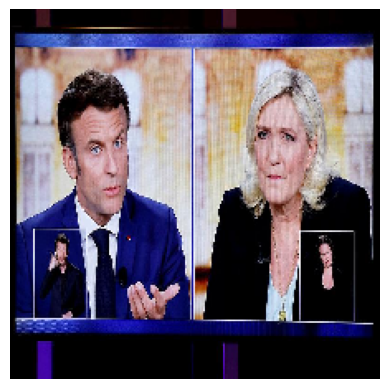


Generated title
macron ve le pen canlı yayında tartıştı


In [19]:
generate_text(10)

1/1 [==============================] - 0s 24ms/step


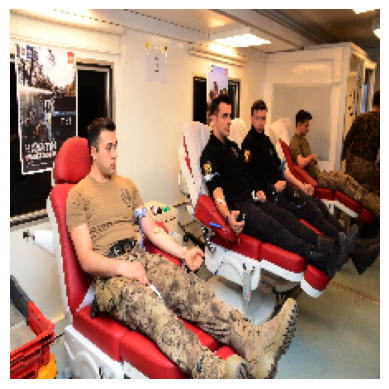


Generated title
kocaeli emniyetinden kan bağışı


In [20]:
generate_text(100)

1/1 [==============================] - 0s 26ms/step


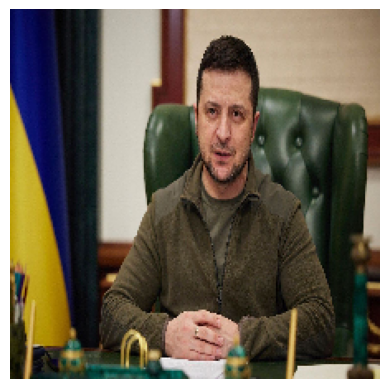


Generated title
zelenskiy ülkesindeki elektrik kesintilerine ilişkin açıklama yaptı


In [21]:
generate_text(999)

1/1 [==============================] - 0s 25ms/step


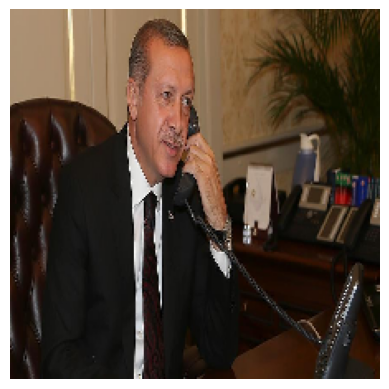


Generated title
başkan erdoğan erkek ve kadın voleybol milli takımlarını tebrik etti


In [22]:
generate_text(46)